In [33]:
from functions import *
import pandas as pd
import seaborn as sns
import statistics
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl

DPI = 300
GRANULARITY = 200000

blocks_HDD = pd.read_csv("./raw_data/HDD/eval_all_blocks.csv", names=["BLOCK", "BLOCK_NS"])
blocks_SSD = pd.read_csv("./raw_data/SSD/eval_all_blocks.csv", names=["BLOCK", "BLOCK_NS"])

blocks_info = pd.read_csv("./data/enhanced_block.csv", names=["BLOCK", "SIZE", "VERSION", "numberTX", "numberVin", "numberVout", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"])

# Merge Data
blocks = blocks_SSD.merge(blocks_HDD, how='inner', left_on="BLOCK", right_on="BLOCK", suffixes=('_SSD', '_HDD'))
blocks = blocks.merge(blocks_info, how='inner', left_on="BLOCK", right_on="BLOCK")

if GRANULARITY:
    blocks = blocks.tail(GRANULARITY)

onlyContainingTransparent = blocks.loc[(blocks['numberJoinSplit'] == 0) & (blocks['numbervShieldedSpend'] == 0) & (blocks['numbervShieldedOutput'] == 0)]

print('Blocks ' + blocks.iloc[0]['BLOCK'] + ' till ... ' + blocks.iloc[-1]['BLOCK'])

Blocks 00000000026713f4ef22ffc0096547fe88ccfe3987605e4a73c0abc617f1e926 till ... 00000000009e4f8f692d035202d57fcf3d8e62c1dd9a5802daa4f82794436b51


In [34]:
blocks["SIZE"] = blocks["SIZE"] / 1024 # Convert to KB
onlyContainingTransparent.sort_values(by=['SIZE']).tail()

,BLOCK,BLOCK_NS_SSD,BLOCK_NS_HDD,SIZE,VERSION,numberTX,numberVin,numberVout,numberJoinSplit,numbervShieldedSpend,numbervShieldedOutput
758999,00000000015d046d9d0ff23d15883dc31f1a5f7b9d6d68...,406754303,1132653476,1278484,4,7,8654,14,0,0,0
762395,0000000002aac1f147b52f0160b5d09a3dcdc2d54567fc...,25688300,65086096,1321967,4,4,8951,7,0,0,0
762408,000000000139a5cdff64fd4b4941f5f0a52c28710fbc5b...,407210199,1752388798,1348440,4,5,9130,9,0,0,0
762600,00000000006a37b040661e1b080a6603799c28ae168dad...,424884001,1124479987,1403535,4,9,9501,15,0,0,0
756662,0000000001ac89f63bcfef2dd7e2c3224a22ac37f407c3...,476299500,136224750,1524234,4,8,10320,14,0,0,0


In [41]:
color = "muted"
sns.despine(left=True)
color = sns.color_palette(color, 5)
color_primary = color[0]
color_kb = color[2]
color_r2 = color[3]
color_kv = color[1]
sns.set(style="darkgrid", palette=color, color_codes=True)
sns.despine(left=True)

<Figure size 432x288 with 0 Axes>

In [36]:
blocks.loc[blocks['BLOCK'].isin(onlyContainingTransparent['BLOCK']), 'Type'] = 'Transparent'
blocks.loc[~blocks['BLOCK'].isin(onlyContainingTransparent['BLOCK']), 'Type'] = 'Shielded'

[(1.1168835039081106, 180)]

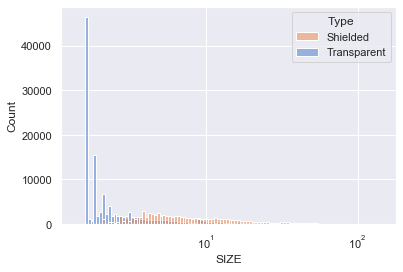

In [49]:
grid = sns.histplot(x="SIZE", data=blocks, hue='Type', log_scale=True, palette=[color_kv, color_primary])

In [38]:
# Include block height
blocks_h = blocks.copy(deep=True)
tmp = blocks_info.copy(deep=True)
tmp = tmp.reset_index()
tmp = tmp.rename(columns = {'index':'height'})
blocks_h = blocks_h.merge(tmp, how='inner', left_on="BLOCK", right_on="BLOCK")
blocks_h = blocks_h.sort_values(by=['height'])

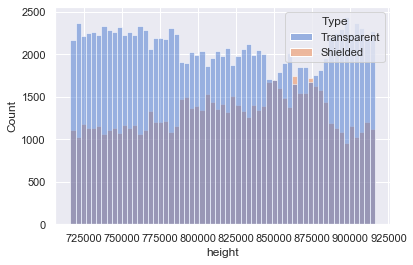

In [48]:
grid = sns.histplot(x="height", data=blocks_h, hue='Type', palette=[color_primary, color_kv])